In [44]:
import json, numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from tqdm import tqdm

In [45]:
labels_dir = './data/BDD100K/labels'
labels_errors_file = 'det_val_errors_2.json' # erroneous labels with 'add_errors_script.py'
error_ids_file = 'error_ids_2.json' # list of labels ids affected by 'add_errors_script.py'
images_dir = './data/BDD100K/100k_images_val/images'
train_label_file = 'det_val.json'
predictions_label_file = 'predictions.json' # detectron2 predictions

In [46]:
with open(os.path.join(labels_dir, predictions_label_file), 'r') as file:
    predictions_data = json.load(file)

print(predictions_data[0])

{'image_id': 0, 'category_id': 'car', 'bbox': [142.1674041748047, 346.76959228515625, 43.2254638671875, 48.638702392578125], 'score': 0.9862108826637268}


In [ ]:
# convert to expected format
def convert_prediction(prediction):
    x1, y1, w, h = prediction["bbox"]
    x2, y2 = x1 + w, y1 + h
    return {
        "id": str(prediction["image_id"]),
        "category": prediction["category_id"],
        "box2d": {
            "x1": x1,
            "y1": y1,
            "x2": x2,
            "y2": y2
        },
        "score": prediction["score"]
    }

In [ ]:
def aggregate_predictions(predictions, id_to_name_map):
    images = {}
    for pred in predictions:
        image_id = pred["image_id"]
        image_name = id_to_name_map.get(image_id, "Unknown")
        if image_name not in images:
            images[image_name] = {
                "name": image_name,
                "labels": []
            }
        images[image_name]["labels"].append(convert_prediction(pred))
    return list(images.values())

In [ ]:
aggregated_data = aggregate_predictions(predictions_data, id_to_name_map)
label_data = json.dumps(aggregated_data, indent=4)

print(label_data)

dict_keys(['misclassification_err', 'size_alternation_err', 'remove_label_err', 'shifting_err'])


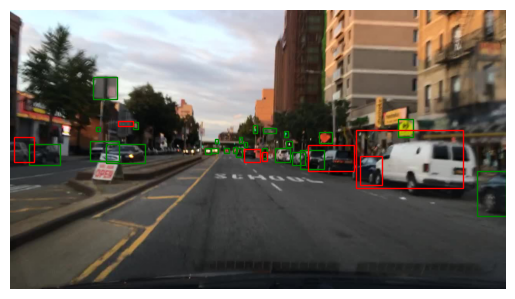

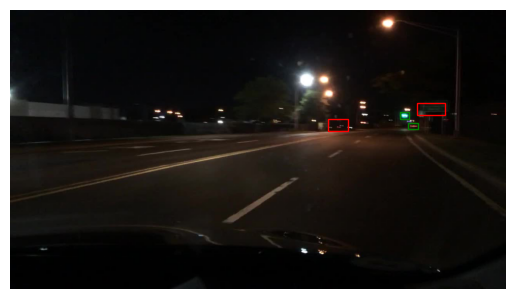

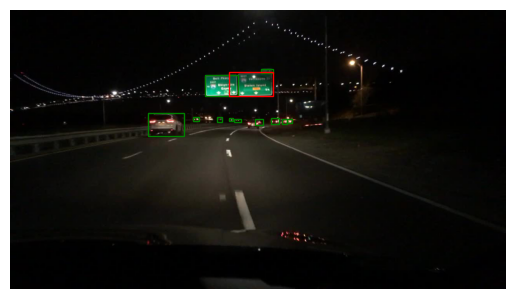

In [3]:
# Read the labels file
# with open(os.path.join(labels_dir, train_label_file), 'r') as file:
#     label_data = json.load(file)
    
# Read the error ids
with open(os.path.join(labels_dir, error_ids_file), 'r') as file:
    error_ids = json.load(file)
print(error_ids.keys())
error_ids_set = {val for sublist in error_ids.values() for val in sublist}

# Read the erroneous labels data
with open(os.path.join(labels_dir, labels_errors_file), 'r') as file:
    error_label_data = json.load(file)

# Plot a single image with bounding boxes
def plot_image_with_boxes(image_path, labels):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for label in labels:
        box = label['box2d']
        x1, y1, x2, y2 = box['x1'], box['y1'], box['x2'], box['y2']
        if label['id'] in error_ids_set:
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        else:
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()

for image_data in error_label_data[:3]:
    image_path = os.path.join(images_dir, image_data['name'])
    plot_image_with_boxes(image_path, image_data['labels'])

In [4]:
def bbox_distance(box1, box2):
    center1 = ((box1['x1'] + box1['x2']) / 2, (box1['y1'] + box1['y2']) / 2)
    center2 = ((box2['x1'] + box2['x2']) / 2, (box2['y1'] + box2['y2']) / 2)
    return np.sqrt((center1[0] - center2[0]) ** 2 + (center1[1] - center2[1]) ** 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
def create_category_mapping(label_data, error_label_data):
    categories = set()
    for item in label_data + error_label_data:
        for label in item['labels']:
            categories.add(label['category'])
    category_to_number = {cat: i for i, cat in enumerate(categories)}
    return category_to_number

category_to_number = create_category_mapping(label_data, error_label_data)
category_to_number

{'car': 0,
 'traffic sign': 1,
 'train': 2,
 'bicycle': 3,
 'trailer': 4,
 'other vehicle': 5,
 'traffic light': 6,
 'other person': 7,
 'pedestrian': 8,
 'bus': 9,
 'truck': 10,
 'motorcycle': 11,
 'rider': 12}

In [6]:
def create_one_hot_vector(category, category_list):
    one_hot = np.zeros(len(category_list), dtype=np.float32)
    index = category_list.index(category)
    one_hot[index] = 1
    return one_hot

def bbox_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area if union_area != 0 else 0
    
    return iou

def normalize_bbox(box, image_width, image_height):
    x1, y1, x2, y2 = box
    return [x1 / image_width, y1 / image_height, x2 / image_width, y2 / image_height]

class BDD100KDataset(Dataset):
    def __init__(self, label_data, error_label_data, categories):
        self.data = []
#         self.categories = sorted(list(set([label['category'] for item in label_data for label in item['labels']] + 
#                                            [label['category'] for item in error_label_data for label in item['labels']])))
        self.categories = sorted(list(category_to_number.keys()))
        label_dict = self.group_labels_by_image(label_data)
        error_dict = self.group_labels_by_image(error_label_data)

        for image_name in tqdm(label_dict.keys(), desc='Processing Images'):
            labels = label_dict.get(image_name, [])
            error_labels = error_dict.get(image_name, [])
            for label in labels:
                image_width, image_height = 1280, 720
                normalized_box = normalize_bbox((label['box2d']['x1'], label['box2d']['y1'], label['box2d']['x2'], label['box2d']['y2']), image_width, image_height)
                min_distance = float('inf')
                closest_box = None
                for error_label in error_labels:
                    error_normalized_box = normalize_bbox((error_label['box2d']['x1'], error_label['box2d']['y1'], error_label['box2d']['x2'], error_label['box2d']['y2']), image_width, image_height)
                    distance = np.linalg.norm(np.array(normalized_box) - np.array(error_normalized_box))
                    if distance < min_distance:
                        min_distance = distance
                        closest_box = error_normalized_box
                        closest_error_category = error_label['category']
                if closest_box:
                    erroneous = 1 if label['id'] in error_ids_set else 0
                    category_vector = create_one_hot_vector(label['category'], self.categories)
                    error_category_vector = create_one_hot_vector(closest_error_category, self.categories)
                    iou = bbox_iou(np.array(normalized_box), np.array(closest_box))
                    iou_feature = np.array([iou])
                    
                    full_feature = np.concatenate([normalized_box, closest_box, [1] if label['category'] != closest_error_category else [0], iou_feature])
                    if label['category'] != closest_error_category:
                        #print(label['category'], closest_error_category, erroneous)
                        pass
                    
                    self.data.append((full_feature, erroneous))
                    #self.data.append((normalized_box + closest_box, erroneous, category_to_number[label['category']], category_to_number[closest_error_category]))
                    #self.data.append(([normalized_box[i] - closest_box[i] for i in range(len(closest_box))], erroneous, category_to_number[label['category']] - category_to_number[closest_error_category]))

    def group_labels_by_image(self, data):
        grouped_data = {}
        for item in data:
            image_name = item['name']
            if image_name not in grouped_data:
                grouped_data[image_name] = []
            grouped_data[image_name].extend(item['labels'])
        return grouped_data
    
    def __getitem__(self, idx):
        features, erroneous = self.data[idx]
        features_tensor = torch.tensor(features, dtype=torch.float32)
        erroneous_tensor = torch.tensor([erroneous], dtype=torch.float32)
        return features_tensor, erroneous_tensor

    def __len__(self):
        return len(self.data)

dataset = BDD100KDataset(error_label_data, label_data, category_to_number)

# for elem in dataset:
#     features, erroneous, category_vector, error_category_vector = elem
#     # Convert tensors to numpy arrays for easier manipulation
#     category_vector = category_vector.numpy()
#     error_category_vector = error_category_vector.numpy()

#     # Check if the categories match by comparing the one-hot vectors
#     if not np.array_equal(category_vector, error_category_vector) and erroneous.item() != 1:
#         print(f"Error in data: Category mismatch not marked erroneous")
#         print(f"Features: {features}, Erroneous: {erroneous}, Category Vector: {category_vector}, Error Category Vector: {error_category_vector}")
#     assert np.array_equal(category_vector, error_category_vector) or erroneous.item() == 1, "Category mismatch must mark the label as erroneous"
#     if (np.array_equal(category_vector, error_category_vector) and not (features[0] == features[4] and features[1] == features[5] and features[2] == features[6] and features[3] == features[7])) and erroneous.item() != 1:
#         print(f"Error in data: Category mismatch not marked erroneous 2")
#         print(f"Features: {features}, Erroneous: {erroneous}, Category Vector: {category_vector}, Error Category Vector: {error_category_vector}")

Processing Images: 100%|██████████| 10000/10000 [00:35<00:00, 278.35it/s]


In [7]:
from torch.utils.data.dataset import random_split

total_size = len(dataset)
val_size = int(total_size * 0.6)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

from torch.utils.data import WeightedRandomSampler
import numpy as np

def make_sampler(labels):
    labels = labels.astype(np.int64)
    class_counts = np.bincount(labels)
    class_weights = 1. / np.where(class_counts == 0, 1, class_counts)
    weights = class_weights[labels]
    return WeightedRandomSampler(weights, len(weights), replacement=True)

all_labels = [int(label.item()) for _, label in train_dataset] 

sampler = make_sampler(np.array(all_labels))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

def check_class_distribution(dataset):
    erroneous_count = 0
    total_count = 0
    for _, label in dataset:
        erroneous_count += int(label.item())
        total_count += 1
    return erroneous_count, total_count - erroneous_count

train_erroneous, train_non_erroneous = check_class_distribution(train_dataset)
val_erroneous, val_non_erroneous = check_class_distribution(val_dataset)

print(f"Training set: {train_erroneous} erroneous, {train_non_erroneous} non-erroneous")
print(f"Validation set: {val_erroneous} erroneous, {val_non_erroneous} non-erroneous")

Training set: 16322 erroneous, 50644 non-erroneous
Validation set: 24645 erroneous, 75803 non-erroneous


In [8]:
inputs, classes = next(iter(train_loader))  
inputs, classes

(tensor([[3.0846e-01, 6.0222e-01, 3.1849e-01, 6.4553e-01, 3.0846e-01, 6.0222e-01,
          3.1849e-01, 6.4553e-01, 0.0000e+00, 1.0000e+00],
         [5.1488e-01, 5.9794e-01, 7.7528e-01, 8.5158e-01, 5.1488e-01, 5.9794e-01,
          7.7528e-01, 8.5158e-01, 0.0000e+00, 1.0000e+00],
         [5.1301e-01, 1.9820e-01, 5.2080e-01, 2.1622e-01, 5.1301e-01, 1.9820e-01,
          5.2080e-01, 2.1622e-01, 0.0000e+00, 1.0000e+00],
         [5.4780e-01, 3.9481e-01, 5.6929e-01, 4.4408e-01, 5.4780e-01, 3.9481e-01,
          5.6929e-01, 4.3302e-01, 0.0000e+00, 7.7555e-01],
         [8.1599e-01, 2.3092e-01, 8.3399e-01, 2.8211e-01, 8.1297e-01, 2.3886e-01,
          8.3097e-01, 2.9005e-01, 0.0000e+00, 5.4198e-01],
         [3.5273e-01, 3.1813e-01, 3.7223e-01, 3.6707e-01, 3.5273e-01, 3.1813e-01,
          3.7223e-01, 3.6707e-01, 0.0000e+00, 1.0000e+00],
         [3.1873e-01, 4.6553e-01, 3.4330e-01, 4.8321e-01, 3.1873e-01, 4.6553e-01,
          3.4330e-01, 4.8321e-01, 0.0000e+00, 1.0000e+00],
         [4.6

In [9]:
import torch.nn.functional as F
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(10, 20) 
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(20, 20)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        #x = self.dropout3(x)
        return self.fc5(x)

In [10]:
model = SimpleNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
total_samples = train_erroneous + train_non_erroneous
weight = torch.tensor([total_samples / train_non_erroneous, total_samples / train_erroneous])

criterion = nn.BCEWithLogitsLoss()
losses = []
best_loss = float('inf')
best_model_path = 'best_model.pth'
train_losses = []
val_losses = []
best_val_loss = float('inf')

def validate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.inference_mode():
        for data in data_loader:
            features_tensor, erroneous_tensor = data
            features_tensor, erroneous_tensor = features_tensor.to(device), erroneous_tensor.to(device)

            predictions = model(features_tensor)
            loss = criterion(predictions.squeeze(), erroneous_tensor.squeeze())
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    return avg_loss

epochs = 40

for epoch in range(epochs):
    model.train()
    total_loss = 0
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}') as t:
        for data in t:
            features_tensor, erroneous_tensor = data
            features_tensor, erroneous_tensor = features_tensor.to(device), erroneous_tensor.to(device)
            predictions = model(features_tensor)
            loss = criterion(predictions.squeeze(), erroneous_tensor.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            t.set_postfix(loss=loss.item())
    print(f"full_features: erroneous_tensor: {erroneous_tensor.squeeze()}")
    print(f"predictions: {predictions.squeeze()}")

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    avg_val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved at epoch {epoch+1} with validation loss {best_val_loss}")

Epoch 1/40: 100%|██████████| 1047/1047 [00:08<00:00, 121.23it/s, loss=0.272]


full_features: erroneous_tensor: tensor([0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([-0.8763, -0.8763, -0.8763, -0.8763, -0.8763, 22.7271,  9.6575,  3.7792,
        -0.8763, -0.8763, -0.8763, -0.8763, -0.8763,  8.1734,  3.3150, -0.8763,
        -0.8763, -0.8763, -0.8763, -0.8763, -0.8763, -0.8763], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
New best model saved at epoch 1 with validation loss 0.2665584214268976


Epoch 2/40: 100%|██████████| 1047/1047 [00:09<00:00, 113.82it/s, loss=0.122]


full_features: erroneous_tensor: tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
        1., 0., 0., 0.], device='cuda:0')
predictions: tensor([-1.6301, 22.5017, -1.6301, -1.6301, -1.6301, -1.6301, 14.2486, -1.6301,
        -1.6301, -1.6301, 12.4606, 14.2008,  5.8920, -1.6301, -1.6301, -1.6301,
         5.6271, -1.6301, 33.7544, -1.6301, -1.6301, -1.6301], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
New best model saved at epoch 2 with validation loss 0.13726114995635239


Epoch 3/40: 100%|██████████| 1047/1047 [00:09<00:00, 113.79it/s, loss=0.0691]


full_features: erroneous_tensor: tensor([0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 1., 0., 0.], device='cuda:0')
predictions: tensor([-2.2414, 42.0866, -2.2414, -2.2414,  7.7506, -2.2414, -2.2414, -2.2414,
         6.2096,  7.0935, -2.2414, -2.2414, -2.2414, -2.2414, -2.2414, 17.0929,
        -2.2414,  7.0154, -2.2414, 41.8077, -2.2414, -2.2414], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
New best model saved at epoch 3 with validation loss 0.07900613706535214


Epoch 4/40: 100%|██████████| 1047/1047 [00:09<00:00, 110.75it/s, loss=0.044] 


full_features: erroneous_tensor: tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        1., 1., 0., 0.], device='cuda:0')
predictions: tensor([49.0081, -2.7766,  7.2552, -2.7766, -2.7766, -2.7766, -2.7766, -2.7766,
        -2.7766, -2.7766, 10.5899, -2.7766, -2.7766, -2.7766, -2.7766, 49.3101,
        -2.7766, -2.7766, 49.5487, 20.7929, -2.7766, -2.7766], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
New best model saved at epoch 4 with validation loss 0.04882015677489293


Epoch 5/40: 100%|██████████| 1047/1047 [00:08<00:00, 117.56it/s, loss=0.0289]


full_features: erroneous_tensor: tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0.], device='cuda:0')
predictions: tensor([-3.2672, -3.2672, -3.2672, -3.2672, -3.2672,  9.5782, 20.3537, -3.2672,
        -3.2672, -3.2672, -3.2672, -3.2672, 57.6228, -3.2672, -3.2672, 24.2092,
        -3.2672, -3.2672, -3.2672, 29.7317, -3.2672, -3.2672], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
New best model saved at epoch 5 with validation loss 0.031972466696314754


Epoch 6/40: 100%|██████████| 1047/1047 [00:09<00:00, 116.11it/s, loss=0.021] 


full_features: erroneous_tensor: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0.], device='cuda:0')
predictions: tensor([-3.3336, -3.7310, -3.7310, -3.7310, -3.7310, -3.7310, 15.6589, -3.7310,
        -3.7310, -3.7310, -3.7310, -3.7310, -3.7310, -3.7310, -3.7310, -3.7310,
        -3.7310, -3.7310, 28.1047, 66.0726, -3.7310, -3.7310], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
New best model saved at epoch 6 with validation loss 0.024052159485235147


Epoch 7/40: 100%|██████████| 1047/1047 [00:09<00:00, 114.62it/s, loss=0.0118] 


full_features: erroneous_tensor: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 0.], device='cuda:0')
predictions: tensor([-4.1739, 29.2017, -4.1739, 29.5362, -4.1739, -4.1739, -4.1739, -4.1739,
        -4.1739, -4.1739, -4.1739, -4.1739, -4.1739, -4.1739, -4.1739, -4.1739,
        -4.1739, -4.1739,  7.9255, 29.7012, 70.9098, -4.1739], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
New best model saved at epoch 7 with validation loss 0.016263786249550855


Epoch 8/40: 100%|██████████| 1047/1047 [00:09<00:00, 114.65it/s, loss=0.00727]


full_features: erroneous_tensor: tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([ -4.6007,  12.1087,  -4.6007,  -4.6007,  76.7262,  76.4627,  -4.6007,
         -4.6007,  -4.6007,  -4.6007,  -4.6007,  -4.6007,  -4.6007,  76.2451,
         76.2122,  -4.6007,  -4.6007, 106.9412,  -4.6007,  -4.6007,  -4.6007,
         -4.6007], device='cuda:0', grad_fn=<SqueezeBackward0>)
New best model saved at epoch 8 with validation loss 0.012855758977709872


Epoch 9/40: 100%|██████████| 1047/1047 [00:09<00:00, 115.96it/s, loss=0.00576]


full_features: erroneous_tensor: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([ -5.0068, 110.7883,  -5.0068,  -5.0068,  -5.0068,  -5.0068,  -5.0068,
         -5.0068,  -5.0068,  -5.0068,  10.4842,  11.9479,  -5.0068,  -5.0068,
         -5.0068,  -5.0068,  -5.0068,  -5.0068,  -5.0068,  -5.0068,  -5.0068,
         -5.0068], device='cuda:0', grad_fn=<SqueezeBackward0>)
New best model saved at epoch 9 with validation loss 0.01066313158486418


Epoch 10/40: 100%|██████████| 1047/1047 [00:09<00:00, 115.77it/s, loss=0.00336]


full_features: erroneous_tensor: tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        1., 0., 0., 0.], device='cuda:0')
predictions: tensor([-5.3737, 15.0048, -5.3737, -5.3737, -5.3737, -5.3737, -5.3737, 15.9476,
        -5.3737, -5.3737, -5.3737, -5.3737, -5.3737, 42.5454, 32.3632, 28.8020,
        -5.3737, -5.3737, 29.6346, -5.3737, -5.3737, -5.3737], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
New best model saved at epoch 10 with validation loss 0.009600045092279318


Epoch 11/40: 100%|██████████| 1047/1047 [00:09<00:00, 115.51it/s, loss=0.00245]


full_features: erroneous_tensor: tensor([0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0.], device='cuda:0')
predictions: tensor([ -5.6928,  -5.6928,  38.4322,  -5.6928,  -5.6928,  -5.6928,  46.1030,
         -5.6928,  -5.6928,  88.0130,  -5.6928,  -5.6928,  -5.6928, 103.8410,
         -5.6928,  -5.6928,  -5.6928,  37.3769,  -5.6928,  -5.6928,  88.5814,
         -5.6928], device='cuda:0', grad_fn=<SqueezeBackward0>)
New best model saved at epoch 11 with validation loss 0.008858668180864756


Epoch 12/40: 100%|██████████| 1047/1047 [00:09<00:00, 114.53it/s, loss=0.00109] 


full_features: erroneous_tensor: tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([-6.6913, -6.7029, -6.6955, -6.6646, -6.6679, -6.7023, -6.6947, 38.3998,
        36.1869, -6.6625, -6.7324, -6.6972, -6.6355, -6.6245, 88.3827, -6.6507,
        -6.6973, -6.6698, -6.6504, -6.6551, -6.6560, -6.6602], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
New best model saved at epoch 12 with validation loss 0.008557045257911323


Epoch 13/40: 100%|██████████| 1047/1047 [00:09<00:00, 114.23it/s, loss=0.000799]


full_features: erroneous_tensor: tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([-7.1134, -7.0547, 10.2911, -7.0493,  7.1270, 45.1840, -7.1740, -7.1356,
        -7.2431, -7.0917, -7.1581, 13.1852, 82.8130,  5.5412, -7.0802, -7.0818,
        -7.1574, -7.1588, -7.1471, -7.2888, -7.0346, -7.1125], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


Epoch 14/40: 100%|██████████| 1047/1047 [00:09<00:00, 115.25it/s, loss=0.00173] 


full_features: erroneous_tensor: tensor([1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
        1., 0., 0., 0.], device='cuda:0')
predictions: tensor([13.6659, 42.5894, -3.8709, -5.7572, -5.9199, -6.9298, -6.2063, 38.7413,
        18.6440, 35.1580, 38.7183, -6.8126, 14.5108, -6.8512, -6.8732, -6.7857,
        40.9718, -6.8793, 12.0681, -6.9876, -6.6459, -6.9208], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
New best model saved at epoch 14 with validation loss 0.006927775389775871


Epoch 15/40: 100%|██████████| 1047/1047 [00:08<00:00, 116.69it/s, loss=0.0193]  


full_features: erroneous_tensor: tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0.], device='cuda:0')
predictions: tensor([ -5.8576,  -6.1606,  -4.3750,  41.5572,  -5.3549,  -2.8436,  -5.9584,
         -0.9963, 130.0752,  -5.6269,  -6.3969,  -5.3955,  -6.7252,  -6.0967,
         -6.0180,  22.7609,  -6.0403,  -5.7506,  -5.8592,  -6.2968,  17.4320,
         -5.5770], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 16/40: 100%|██████████| 1047/1047 [00:09<00:00, 112.33it/s, loss=0.00058] 


full_features: erroneous_tensor: tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 1.], device='cuda:0')
predictions: tensor([ 22.1363,  -7.5676,  86.0062,  -7.8342,  90.6572,  36.8363,  -7.4776,
         -5.6344,  -7.3263,  -7.8564,  -7.7528,  -7.6581, 125.4288,  -7.6970,
         -7.3647,  -7.7213,  -6.2451,  90.3879,  -7.2237,  -6.8185,  -7.6460,
         38.7674], device='cuda:0', grad_fn=<SqueezeBackward0>)
New best model saved at epoch 16 with validation loss 0.00649995077603458


Epoch 17/40: 100%|██████████| 1047/1047 [00:09<00:00, 115.41it/s, loss=0.00254] 


full_features: erroneous_tensor: tensor([0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([-6.4863, 40.9552, 44.6872, 45.1349, -6.5592, -6.5174, -6.6152, -5.0324,
        -5.7965, -4.3613, -6.1939, -6.2660, -6.8301, 44.1353, -5.4579, -5.8441,
        18.4561, -4.7881, -6.3494, -6.2828, -6.3315, -6.2151], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


Epoch 18/40: 100%|██████████| 1047/1047 [00:09<00:00, 114.07it/s, loss=0.000784]


full_features: erroneous_tensor: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 1., 0.], device='cuda:0')
predictions: tensor([-8.3191, -8.3305, 14.2729, -8.0517, -8.2792, -8.3089, -8.3209, -8.2459,
        -8.2971, 88.4513, -8.2578, -8.1661, -5.1557, 34.9294, 12.7349, -8.1709,
        -8.3742, -8.3320, -8.1738, -8.3410,  4.9075, -8.2669], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


Epoch 19/40: 100%|██████████| 1047/1047 [00:09<00:00, 115.16it/s, loss=0.000607]


full_features: erroneous_tensor: tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1.], device='cuda:0')
predictions: tensor([-5.3849, -6.7046, -8.2604, -8.2762, -8.3587, 42.4342, -7.0973, 87.5838,
        -6.1818, -8.2330, -8.4235, -8.3952, -7.5085, 21.1451, -8.4749, -7.1197,
        -8.1905, -8.4329, -8.4760, -7.2601, -8.3722, 41.0672], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


Epoch 20/40: 100%|██████████| 1047/1047 [00:09<00:00, 113.28it/s, loss=0.000885]


full_features: erroneous_tensor: tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.], device='cuda:0')
predictions: tensor([40.4957, -8.1010, -8.5212, -8.6248, -8.4948, -5.7786, -8.0296, 43.1830,
        -6.2166, -7.1761, -8.6823, -8.5402, 46.4734, -8.5098, -4.7042, -8.5571,
        -8.6858, -8.5094, 45.6398, -8.5727, -8.7032, -6.2627], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
New best model saved at epoch 20 with validation loss 0.006281494939919253


Epoch 21/40: 100%|██████████| 1047/1047 [00:09<00:00, 111.71it/s, loss=0.000936]


full_features: erroneous_tensor: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 1.], device='cuda:0')
predictions: tensor([ -7.8186,  53.2631,  -5.2805,  -6.7701,  -7.8224,  -8.0286,  -8.3341,
         -7.6226,  -7.7811,  53.6424,  -8.3634,  -6.4909,  -8.0391,  19.3746,
         -5.5411,  -5.6945,  -6.1167,  -7.6274,  49.5620,   9.8205,  22.5261,
        107.4254], device='cuda:0', grad_fn=<SqueezeBackward0>)
New best model saved at epoch 21 with validation loss 0.005818214225393696


Epoch 22/40: 100%|██████████| 1047/1047 [00:09<00:00, 113.82it/s, loss=0.000401]


full_features: erroneous_tensor: tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([128.1981,  46.8334,  -6.1333,  -8.0156,  -8.3329,  -8.6021,  49.3541,
         -8.7376,  -8.8042,  -8.6976, 106.3690,  -8.7748,  -6.0405,  -8.7840,
         18.4293,  -8.4508,  -8.6593,  -6.9304,  -8.7497,  -7.0510,  -8.6088,
         -8.6654], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 23/40: 100%|██████████| 1047/1047 [00:09<00:00, 113.61it/s, loss=0.000236]


full_features: erroneous_tensor: tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([ -8.8209,  -7.8147,  -8.5590,  -6.9642,  -8.9709,  -8.8699, 101.9182,
         -8.7188,  -8.9072,  -8.7870,  -8.8647,  10.9490,  -9.0038,  -8.7706,
         -9.0271,  -7.7398,  -8.6047,  21.3613,  -7.0964,  -7.6292,  -8.7640,
         -8.8145], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 24/40: 100%|██████████| 1047/1047 [00:09<00:00, 112.98it/s, loss=0.00375] 


full_features: erroneous_tensor: tensor([0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0.], device='cuda:0')
predictions: tensor([ -8.1116,  -6.9873,  -8.9096,  -6.2207,  -8.3876,  -6.2723,  36.3452,
         -8.5769, 105.4052, 114.1888,  -7.5465,  -8.7652,  -8.9255,  -2.5979,
         -8.7771,  -8.8617,  -6.0297,  -6.8462,  56.1381,  -8.6504,  -8.6098,
         -9.1746], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 25/40: 100%|██████████| 1047/1047 [00:09<00:00, 113.30it/s, loss=0.000131]


full_features: erroneous_tensor: tensor([0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 0., 1., 0.], device='cuda:0')
predictions: tensor([ -8.6515,  -9.4428,  -9.1830,  18.5919,  14.4359,  -9.2264,  -9.0893,
         64.4659,  -9.0153,  19.0025,  -8.5293, 115.2918,  -9.2191,  -8.9312,
        110.2722,  -9.1055,  24.3326,  -8.9787,  -9.2444,  -9.3603,   6.7199,
         -8.8455], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 26/40: 100%|██████████| 1047/1047 [00:09<00:00, 112.63it/s, loss=0.000472]


full_features: erroneous_tensor: tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 1., 0., 0.], device='cuda:0')
predictions: tensor([ -8.3153,  -6.9574,  -8.5618,  -8.0386,  75.6595, 119.2486,  -7.8751,
         -8.1616,  -6.6601,  60.2022,  -6.8861,  -8.5381,  -7.2212,  62.0610,
         23.6304,  -8.4970,  -5.7554,  -8.5188, 111.4555,  65.6336,  -6.9587,
         -8.1956], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 27/40: 100%|██████████| 1047/1047 [00:09<00:00, 112.93it/s, loss=0.00127] 


full_features: erroneous_tensor: tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1.], device='cuda:0')
predictions: tensor([54.2747, -8.9137, -8.9918, -8.9067, -8.7984, -8.5329, -8.5913, 58.1407,
        -9.0710, -4.3524, -9.2936, 21.4078, -4.3478, -8.9436, -9.0330, -8.8181,
        -8.2712, 67.8468, -8.9887, -8.6006, -8.2309, 30.8795], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


Epoch 28/40: 100%|██████████| 1047/1047 [00:09<00:00, 114.81it/s, loss=0.000546]


full_features: erroneous_tensor: tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 0.], device='cuda:0')
predictions: tensor([ -8.9369,  16.1293, 119.7175,  -7.8953,  -8.9963,  -7.0493,  -8.9702,
         -6.3730,  19.7565,  60.2872,  -8.9736,  -6.7329,  -8.9163,  -9.1990,
         -8.6703,  -6.6076,  -8.7755,  -9.0121,  19.3057,  -5.9522, 113.9831,
         -5.8961], device='cuda:0', grad_fn=<SqueezeBackward0>)
New best model saved at epoch 28 with validation loss 0.005624108514527918


Epoch 29/40: 100%|██████████| 1047/1047 [00:09<00:00, 114.27it/s, loss=0.000545]


full_features: erroneous_tensor: tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
        1., 0., 1., 0.], device='cuda:0')
predictions: tensor([ 65.0156,  -7.5866,  64.3404,  -8.6468,  -6.0038,  60.6940,  -5.9286,
         -8.4557,  -9.0431,  39.7357,  -8.6649, 114.3529,  -7.5510,  -8.8023,
         61.1783,  -5.6134,  -8.5595, 151.1185,  16.2174,  -6.9240,  30.4839,
         -8.6262], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 30/40: 100%|██████████| 1047/1047 [00:09<00:00, 112.83it/s, loss=8.76e-5] 


full_features: erroneous_tensor: tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
        0., 1., 0., 0.], device='cuda:0')
predictions: tensor([ 27.8408,  -9.1871,  -8.9091,  -8.3808, 114.8663,  -9.2532,  -9.2485,
        111.3500,  -8.9589,  -9.0068,  66.1767,  -8.8657,  60.2770,  -8.5856,
         -9.1208,  56.0288,  -8.3944,  29.7684,  -9.2415,  57.0195,  -8.9883,
         -8.9372], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 31/40: 100%|██████████| 1047/1047 [00:09<00:00, 113.54it/s, loss=0.00046] 


full_features: erroneous_tensor: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
        0., 0., 0., 1.], device='cuda:0')
predictions: tensor([ -9.0437,  -8.9547,  65.6040,  -9.1364,  -7.9299,  -8.7859,  -9.0476,
         -8.9911,  -9.3511,  -4.8007,  28.9562,  -9.3765,  -9.0450,  20.8076,
        115.9329,  -9.2340,  12.6983,  -9.1404,  -9.2851,  -9.1148,  -9.0632,
        168.5892], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 32/40: 100%|██████████| 1047/1047 [00:09<00:00, 115.65it/s, loss=0.000763]


full_features: erroneous_tensor: tensor([0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([ -8.5827,  -9.0288,  -7.4436, 117.1369,  -9.0412,  -9.1461,  38.3685,
        111.2269,  -6.7023,  59.8993,  -9.1283,  -9.2992,  -9.2964,  -9.2759,
        110.3897,  -4.2988,  -9.2599, 120.0330,  -9.0581,  -8.7863,  -9.3764,
         -9.0315], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 33/40: 100%|██████████| 1047/1047 [00:09<00:00, 114.49it/s, loss=0.000611]


full_features: erroneous_tensor: tensor([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([ -9.3606,  -8.9258,  16.0867, 115.6463,  -7.7081,  63.0648,  -4.6101,
         -9.1406,  -9.0396,  -9.3779,  20.0169,  78.7125,  -9.3716,  76.1427,
         -6.7021,  -9.3066,  -9.3458,  -8.7071,  -7.5335,  -8.5654,  -9.3908,
         -9.3164], device='cuda:0', grad_fn=<SqueezeBackward0>)
New best model saved at epoch 33 with validation loss 0.005587772829715789


Epoch 34/40: 100%|██████████| 1047/1047 [00:09<00:00, 112.07it/s, loss=0.0018]  


full_features: erroneous_tensor: tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([ -8.7434,  19.4484,  -9.1831,  -3.8494,  -9.3200,  -7.7007, 111.5988,
         -9.1898,  -8.7567,  -9.2061,  -4.0882,  22.8040,  -8.9648,  -9.1502,
         -9.0422,  23.7201,  65.4228,  15.5218,  -9.1371,  -9.0178,  -9.2025,
         -9.1234], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 35/40: 100%|██████████| 1047/1047 [00:09<00:00, 113.18it/s, loss=0.000757]


full_features: erroneous_tensor: tensor([0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        1., 0., 0., 0.], device='cuda:0')
predictions: tensor([ -9.0485,  -8.9250,  67.6474,  -4.9205,  25.5835,  -9.4892,  -9.5685,
         -9.1180, 110.8028,  61.1507,  -8.8771,  -9.6073,  -6.1363,  65.4812,
         -9.6587,  -5.2070, 110.2081,  -7.2757, 110.6899,  -9.4544,  -9.2693,
         -9.0693], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 36/40: 100%|██████████| 1047/1047 [00:09<00:00, 113.85it/s, loss=0.00125] 


full_features: erroneous_tensor: tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([ -8.8904,  -8.9319,  -9.0669,  -9.1623,  -9.0125,  59.9791,  60.0559,
         -8.4692,  -9.2928,  66.3617,  -9.2239,  -8.9171, 117.5103,  -3.6862,
         -9.3978,  -8.9990,  -8.8659,  -8.9806,  -8.5003,  -8.9956,  -7.3409,
         -9.0223], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 37/40: 100%|██████████| 1047/1047 [00:09<00:00, 114.69it/s, loss=0.00129] 


full_features: erroneous_tensor: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([ -5.8695,  -6.2186,  -7.7060,  -9.4973,  -9.3868,  -8.4634,  -9.3770,
         -8.7543,  -9.5047,  -9.1979, 109.8396,  -7.7138,  -8.1267,  20.7288,
         -8.7462,  -9.3281,  -9.4487,  -3.9607,  -9.4405,  -6.7822,  -9.3762,
         -6.8983], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 38/40: 100%|██████████| 1047/1047 [00:09<00:00, 114.54it/s, loss=0.00145] 


full_features: erroneous_tensor: tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.], device='cuda:0')
predictions: tensor([108.5762,  27.0922,  -8.8265,  -5.8476,  -6.4980,  -8.5526,  -4.6122,
         -5.0279,  -7.1123,  -9.3910,  64.0335,  16.2797,  -9.0800,  -9.1207,
         -8.7114,  -9.3964,  -8.4660,  21.2629,  -9.0392,  -9.0839,  -9.6562,
         -4.7235], device='cuda:0', grad_fn=<SqueezeBackward0>)
New best model saved at epoch 38 with validation loss 0.005459472791875333


Epoch 39/40: 100%|██████████| 1047/1047 [00:09<00:00, 111.70it/s, loss=0.00062] 


full_features: erroneous_tensor: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.], device='cuda:0')
predictions: tensor([ -9.3725,  61.5004,  -9.5059,  -5.5759,  -9.1254,  -8.4477,  -9.1120,
         -9.5971,  -9.2244,  -9.4988,  -9.3406,  14.4739, 137.3813,  -5.1400,
         -9.2923,  -9.2412,  -9.2606,  -9.2445,  -7.2670,  -6.2930,  -8.6356,
         61.0646], device='cuda:0', grad_fn=<SqueezeBackward0>)


Epoch 40/40: 100%|██████████| 1047/1047 [00:09<00:00, 112.83it/s, loss=0.00119] 


full_features: erroneous_tensor: tensor([1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 1.], device='cuda:0')
predictions: tensor([35.0719, -5.8477, -5.5366, 64.2199, -9.3532, -7.4711, -5.8211, -8.6701,
        73.4944, -9.3919, -8.3795, 35.1109, -8.5015, 70.0230, 72.4869, -4.3397,
        -9.2598, -9.3319, -6.8275, -8.3058, -7.4826, 41.7103], device='cuda:0',
       grad_fn=<SqueezeBackward0>)


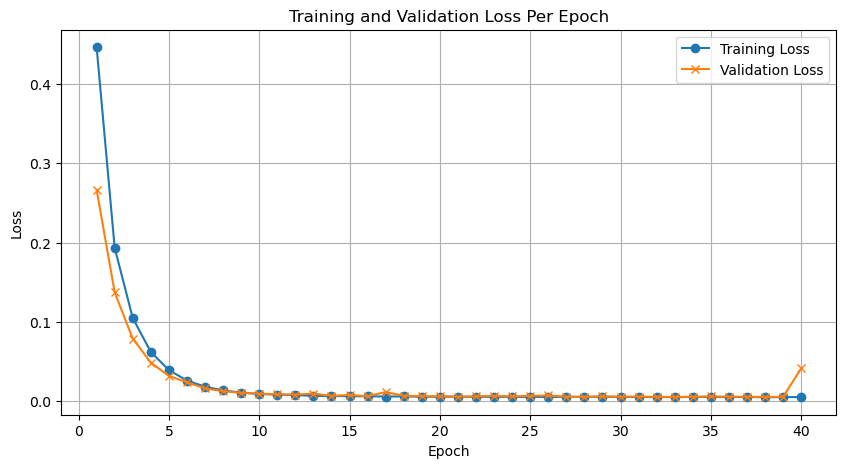

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def perform_inference(model, data_loader, device, num_examples=5):
    model.eval()
    examples = iter(data_loader)
    print("Example predictions:")
    for i in range(num_examples):
        data = next(examples)
        features_tensor, erroneous_tensor = data
        features_tensor, erroneous_tensor = features_tensor.to(device), erroneous_tensor.to(device)

        with torch.inference_mode():
            predictions = model(features_tensor)
            predicted_probs = torch.sigmoid(predictions).squeeze() 

        binary_predictions = (predicted_probs > 0.5).int()

        print(f"\nExample {i+1}:")
        print(f"True Labels: {erroneous_tensor.cpu().squeeze().numpy()}")
        #print(f"Predicted Probabilities: {predicted_probs.cpu().numpy()}")
        print(f"Binary Predictions: {binary_predictions.cpu().numpy()}")
        
model.load_state_dict(torch.load(best_model_path))
perform_inference(model, val_loader, device, num_examples=2)

Example predictions:

Example 1:
True Labels: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Binary Predictions: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]

Example 2:
True Labels: [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Binary Predictions: [0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1
 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]


In [37]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


def collect_predictions_and_labels(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_predictions_iou = []
    all_labels = []
    error_list = []

    with torch.inference_mode():
        for data in data_loader:
            features_tensor, erroneous_tensor = data
            features_tensor, erroneous_tensor = features_tensor.to(device), erroneous_tensor.to(device)
            
            is_label_not_equal = features_tensor[:, -2]
            ious = features_tensor[:, -1]

            predictions = model(features_tensor)
            predicted_probs = torch.sigmoid(predictions).squeeze()
            if predicted_probs.ndim > 1:
                predicted_probs = predicted_probs.squeeze()
            predicted_labels = (predicted_probs > 0.5).int()
            predicted_labels_iou = ((ious < 0.99) | (is_label_not_equal > 0)).int()
            #print(ious, last_feature, predicted_labels)
            all_predictions_iou.extend(predicted_labels_iou.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_labels.extend(erroneous_tensor.cpu().numpy())
            
            # Checking incorrect predictions due to bbox normalization (47 samples)
            if erroneous_tensor.ndim > 1:
                erroneous_tensor = erroneous_tensor.squeeze()
            if predicted_labels_iou.ndim > 1:
                predicted_labels_iou = predicted_labels_iou.squeeze()

            error_mask = (erroneous_tensor == 1) & (predicted_labels_iou == 0)
            if error_mask.any():
                erroneous_features = features_tensor[error_mask].cpu().numpy()
                for feature in erroneous_features:
                    error_list.append(feature)
                    print(feature)
    print(len(error_list))

    return all_predictions, all_predictions_iou, all_labels

predictions, all_predictions_iou, labels = collect_predictions_and_labels(model, val_loader, device)

[0.07927733 0.25999996 0.1030078  0.284565   0.07927733 0.25999996
 0.1030078  0.28031248 0.         0.8268866 ]
[0.4729739  0.44336468 0.5134931  0.50160813 0.4729739  0.44336468
 0.5057359  0.50160813 0.         0.8085541 ]
[0.4860528  0.21169536 0.49707156 0.26771465 0.4860528  0.22200727
 0.49707156 0.26771465 0.         0.8159222 ]
[0.3240273  0.5634758  0.35953614 0.6047129  0.33054128 0.5634758
 0.35953614 0.6047129  0.         0.8165532 ]
[0.63070065 0.86996186 0.6414236  0.93738085 0.63070065 0.86996186
 0.6414236  0.9254176  0.         0.82255363]
[0.16156451 0.5196488  0.25273743 0.68669844 0.16156451 0.5523383
 0.25273743 0.68669844 0.         0.80431235]
[0.47079995 0.39765298 0.7020343  0.7098978  0.5119323  0.39765298
 0.7020343  0.7098978  0.         0.8221184 ]
[0.64262164 0.3526064  0.6822099  0.415273   0.64262164 0.3526064
 0.6822099  0.4037912  0.         0.8167795 ]
[0.         0.3101857  0.01640762 0.41390598 0.         0.3284358
 0.01640762 0.41390598 0.        

[0.         0.57188725 0.4591345  0.9496795  0.08188386 0.57188725
 0.4591345  0.9496795  0.         0.82165605]
[0.53458464 0.02252889 0.59793204 0.05892172 0.53458464 0.02252889
 0.58722425 0.05892172 0.         0.83096695]
[0.40815505 0.35676453 0.42359996 0.39355925 0.40815505 0.3630508
 0.42359996 0.39355925 0.         0.8291536 ]
[0.28160906 0.23957002 0.3038404  0.27457646 0.28160906 0.24545471
 0.3038404  0.27457646 0.         0.83189666]
[0.40948907 0.41598436 0.43609264 0.44362217 0.41417906 0.41598436
 0.43609264 0.44362217 0.         0.82370794]
[0.5563619  0.39276433 0.61859095 0.5344939  0.5681189  0.39276433
 0.61859095 0.5344939  0.         0.81106937]
[0.95730954 0.41296846 1.         0.4387497  0.95730954 0.41296846
 0.9929052  0.4387497  0.         0.8338083 ]
[0.18002734 0.5442521  0.23216252 0.5782679  0.18911134 0.5442521
 0.23216252 0.5782679  0.         0.82576084]
[0.5110501  0.48998126 0.60005057 0.59747565 0.5110501  0.48998126
 0.60005057 0.5767488  0.      

[0.05686537 0.5712234  0.24415971 1.         0.05686537 0.5712234
 0.24415971 0.9721007  0.         0.9349327 ]
[0.68642735 0.32580718 0.72471094 0.34706703 0.68642735 0.32580718
 0.7175199  0.34706703 0.         0.81216383]
[0.32270715 0.51431584 0.37143356 0.6220072  0.32270715 0.51431584
 0.36270034 0.6220072  0.         0.8207703 ]
[0.52312464 0.3623435  0.5588713  0.385781   0.52312464 0.3623435
 0.55212855 0.385781   0.         0.8113732 ]
[0.15574756 0.48796842 0.17878291 0.5278121  0.15574756 0.48796842
 0.17420459 0.5278121  0.         0.80124766]
[0.6423009  0.38116688 0.7010675  0.49084705 0.6423009  0.38116688
 0.7010675  0.47094923 0.         0.81858325]
[0.2622233  0.5181645  0.31193852 0.6047077  0.2622233  0.5181645
 0.31193852 0.5892172  0.         0.8210078 ]
[0.8057732  0.5978669  1.         0.99028367 0.8057732  0.5978669
 1.         0.99028367 0.         1.        ]
[0.593043   0.59318197 0.61514014 0.66788554 0.593043   0.59318197
 0.6110519  0.66788554 0.        

[0.08775519 0.5391442  0.10834841 0.6017319  0.08775519 0.54986745
 0.10834841 0.6017319  0.         0.82866824]
[0.5887839  0.12729955 0.60438085 0.209692   0.5887839  0.14210533
 0.60438085 0.209692   0.         0.8203017 ]
[0.81997603 0.6374999  0.8516692  0.6859374  0.825302   0.6374999
 0.8516692  0.6859374  0.         0.83195233]
[0.24175234 0.44711187 0.29320046 0.49563563 0.24175234 0.44711187
 0.28366908 0.49563563 0.         0.81473804]
[0.46672517 0.4104348  0.48690787 0.44401962 0.46672517 0.41710934
 0.48690787 0.44401962 0.         0.8012634 ]
[0.56575507 0.44181105 0.67985046 0.60986704 0.56575507 0.4743773
 0.67985046 0.60986704 0.         0.80621797]
[0.12799634 0.50801665 0.14538364 0.61265796 0.13114314 0.50801665
 0.14538364 0.61265796 0.         0.81901705]
[0.43375754 0.43975338 0.7675963  0.74632144 0.43375754 0.49924573
 0.7675963  0.74632144 0.         0.8059408 ]
[0.2262036  0.22685225 0.24202289 0.28329292 0.2262036  0.22685225
 0.23907436 0.28329292 0.      

[0.         0.66390085 0.05958228 0.9819766  0.         0.66390085
 0.05958228 0.9819766  0.         1.        ]
[0.3038793  0.53763837 0.36323062 0.59457713 0.31570512 0.53763837
 0.36323062 0.59457713 0.         0.80074877]
[0.6032292  0.47850296 0.66182667 0.6107651  0.6032292  0.50233984
 0.66182667 0.6107651  0.         0.8197754 ]
[0.16988392 0.6228855  0.1859055  0.6709093  0.16988392 0.6228855
 0.18289036 0.6709093  0.         0.81180644]
[0.4068066  0.35517865 0.42435762 0.39314356 0.4068066  0.3619417
 0.42435762 0.39314356 0.         0.8218604 ]
[0.4257858  0.32584503 0.4801257  0.4400611  0.4257858  0.3453498
 0.4801257  0.4400611  0.         0.82922935]
[0.5595397  0.5822852  0.57888836 0.6117461  0.5595397  0.5822852
 0.5751366  0.6117461  0.         0.806098  ]
[0.59014493 0.3637698  0.6535026  0.39911723 0.60226583 0.3637698
 0.6535026  0.39911723 0.         0.8086908 ]
[0.19691119 0.24643141 0.22030658 0.31327212 0.19691119 0.24643141
 0.22030658 0.30188715 0.         

[0.16283347 0.54520166 0.18989402 0.59666204 0.16742003 0.54520166
 0.18989402 0.59666204 0.         0.8305075 ]
[0.31916395 0.36509898 0.36838827 0.43754953 0.31916395 0.37885386
 0.36838827 0.43754953 0.         0.81014824]
[0.76798505 0.32372463 0.79347956 0.3543369  0.76798505 0.32372463
 0.7884947  0.3543369  0.         0.80447346]
[0.44453406 0.4112254  0.50104755 0.4592491  0.4540243  0.4112254
 0.50104755 0.4592491  0.         0.8320712 ]
[0.64804125 0.30327356 0.67261744 0.38330773 0.64804125 0.30327356
 0.67261744 0.3696936  0.         0.8298959 ]
[0.31494087 0.47889486 0.39293256 0.54710543 0.31494087 0.47889486
 0.3796876  0.54710543 0.         0.83017457]
[0.5080924  0.55178595 0.52519155 0.6221942  0.511416   0.55178595
 0.52519155 0.6221942  0.         0.8056257 ]
[0.31631857 0.4414689  0.3560717  0.5182461  0.31631857 0.4414689
 0.34870893 0.5182461  0.         0.8147879 ]
[0.19358107 0.4774775  0.25439188 0.57250005 0.19358107 0.4774775
 0.25439188 0.55495495 0.       

[0.75288814 0.46193832 0.846655   0.5154617  0.75288814 0.46193832
 0.8280062  0.5154617  0.         0.8011153 ]
[0.5699366  0.4951633  0.8493614  0.76124555 0.61704963 0.4951633
 0.8493614  0.76124555 0.         0.8313928 ]
[0.30262923 0.41359252 0.37548444 0.53800756 0.30262923 0.43837652
 0.37548444 0.53800756 0.         0.8007957 ]
[0.9257637  0.22903067 0.9818267  0.25748166 0.9362162  0.22903067
 0.9818267  0.25748166 0.         0.8135589 ]
[0.649222   0.36566126 0.69113874 0.47399417 0.649222   0.36566126
 0.69113874 0.4557768  0.         0.83183914]
[0.44442263 0.61759377 0.48390648 0.6977335  0.44442263 0.61759377
 0.48390648 0.68289    0.         0.81478   ]
[0.36536658 0.4434372  0.42073762 0.5515661  0.36536658 0.4434372
 0.42073762 0.5324996  0.         0.8236689 ]
[0.3581466  0.54849106 0.43556643 0.6401893  0.37109113 0.54849106
 0.43556643 0.6401893  0.         0.83280075]
[0.6771091  0.48812482 0.7034763  0.5341279  0.6771091  0.48812482
 0.7034763  0.5256248  0.      

[0.29881483 0.513824   0.31682655 0.54947823 0.29881483 0.52001905
 0.31682655 0.54947823 0.         0.8262459 ]
[0.71460027 0.4613741  1.         0.6191939  0.71460027 0.4613741
 0.9953169  0.6191939  0.         0.98359114]
[0.55096304 0.23826586 0.5922119  0.33110654 0.55096304 0.25638697
 0.5922119  0.33110654 0.         0.80481505]
[0.5167043  0.2953777  0.54487485 0.33281997 0.52147347 0.2953777
 0.54487485 0.33281997 0.         0.83070534]
[0.34423998 0.48492625 0.3652089  0.5463017  0.34423998 0.49571002
 0.3652089  0.5463017  0.         0.8242986 ]
[0.40808538 0.348719   0.42806894 0.40978298 0.40808538 0.348719
 0.42806894 0.3977747  0.         0.80334914]
[0.68273294 0.36514193 0.70152515 0.40661228 0.68273294 0.37233678
 0.70152515 0.40661228 0.         0.826506  ]
[0.29127127 0.44501987 0.31995806 0.4770357  0.2969467  0.44501987
 0.31995806 0.4770357  0.         0.802159  ]
[0.25312972 0.5781355  0.2659957  0.6299999  0.2556991  0.5781355
 0.2659957  0.6299999  0.         

[0.43919465 0.40092817 0.50716317 0.5301559  0.43919465 0.40092817
 0.4945657  0.5301559  0.         0.81465745]
[0.33344594 0.29009008 0.36385134 0.3529908  0.33344594 0.29009008
 0.36385134 0.34234235 0.         0.8307102 ]
[0.6451679  0.48870367 0.9757928  0.7365215  0.705771   0.48870367
 0.9757928  0.7365215  0.         0.8167013 ]
[0.80789036 0.49499983 0.8216013  0.54697734 0.80789036 0.49499983
 0.8216013  0.5381248  0.         0.8296854 ]
[0.42255163 0.5532647  0.43955907 0.59243995 0.42255163 0.5532647
 0.43646917 0.59243995 0.         0.81832033]
[0.48650622 0.43244472 0.5008681  0.49125415 0.48650622 0.44260338
 0.5008681  0.49125415 0.         0.8272613 ]
[0.40022442 0.43439823 0.42028338 0.46273625 0.40022442 0.4398117
 0.42028338 0.46273625 0.         0.8089677 ]
[0.2533061  0.536418   0.27703655 0.5799722  0.2533061  0.54421836
 0.27703655 0.5799722  0.         0.8209048 ]
[0.3546834  0.45400825 0.45568717 0.5805905  0.3546834  0.45400825
 0.43822768 0.5805905  0.      

[0.30721784 0.66390085 0.3332497  0.6973558  0.31225222 0.66390085
 0.3332497  0.6973558  0.         0.8066064 ]
[0.48058027 0.29869848 0.5127489  0.3569963  0.48058027 0.31020552
 0.5127489  0.3569963  0.         0.8026163 ]
[0.5751366  0.49216965 0.58780915 0.5519275  0.5751366  0.49216965
 0.58780915 0.5406934  0.         0.8120067 ]
[0.49987218 0.31889772 0.51781017 0.3921758  0.49987218 0.31889772
 0.51781017 0.3784253  0.         0.81235176]
[0.245375   0.47310674 0.35062578 0.59961516 0.245375   0.47310674
 0.33143467 0.59961516 0.         0.817663  ]
[0.5324979  0.46340516 0.5496501  0.49758708 0.5324979  0.46986634
 0.5496501  0.49758708 0.         0.81097615]
[7.7964610e-04 4.1581094e-01 3.3754762e-02 4.5046183e-01 7.7964610e-04
 4.1581094e-01 2.7287595e-02 4.5046183e-01 0.0000000e+00 8.0387729e-01]
[0.8671701  0.48120973 1.         0.8295969  0.8671701  0.48120973
 0.999497   0.8295969  0.         0.99621314]
[0.41070715 0.4010611  0.4469638  0.4607452  0.41070715 0.4010611


[0.9036469  0.34757212 0.93289113 0.4557768  0.9036469  0.36566126
 0.93289113 0.4557768  0.         0.8328249 ]
[0.31587544 0.49559212 0.5133774  0.77447367 0.35151067 0.49559212
 0.5133774  0.77447367 0.         0.81957024]
[0.7598754  0.27896738 1.         0.68366617 0.7598754  0.27896738
 1.         0.6066747  0.         0.80975604]
[0.40334076 0.43258768 0.43959045 0.4554414  0.41020715 0.43258768
 0.43959045 0.4554414  0.         0.81058085]
[0.05751366 0.52336353 0.25201052 0.7035946  0.05751366 0.52336353
 0.21835695 0.7035946  0.         0.8269712 ]
[0.19663815 0.7938941  0.22661348 0.83664477 0.19663815 0.80111843
 0.22661348 0.83664477 0.         0.831013  ]
[0.         0.2920692  0.1105691  0.4203106  0.00256732 0.2920692
 0.1105691  0.4203106  0.         0.97678083]
[0.85978055 0.39750454 0.892924   0.53722745 0.85978055 0.42284998
 0.892924   0.53722745 0.         0.818602  ]
[0.47151127 0.59764504 0.49448767 0.62307674 0.47541392 0.59764504
 0.49448767 0.62307674 0.     

[0.89656526 0.24649018 0.93330926 0.33096778 0.89656526 0.26129037
 0.93330926 0.33096778 0.         0.8248036 ]
[0.00105668 0.39735883 0.20159519 0.7132082  0.00105668 0.39735883
 0.1629613  0.7132082  0.         0.8073493 ]
[0.22030658 0.28421065 0.30221406 0.32233647 0.22030658 0.28421065
 0.28854313 0.32233647 0.         0.8330931 ]
[0.7493123  0.5895285  0.99342024 0.75732505 0.7493123  0.5895285
 0.94580585 0.75732505 0.         0.8049454 ]
[0.         0.39020205 0.01502362 0.42551744 0.         0.39638072
 0.01502362 0.42551744 0.         0.8250431 ]
[0.         0.5302955  0.04679077 0.66200286 0.         0.5302955
 0.04679077 0.66200286 0.         1.        ]
[0.38256258 0.4659249  0.42086962 0.5314284  0.38256258 0.4659249
 0.41343737 0.5314284  0.         0.8059818 ]
[0.1925345  0.41414183 0.31472307 0.54170096 0.1925345  0.41414183
 0.2917914  0.54170096 0.         0.8123258 ]
[0.4026929  0.06895729 0.42548615 0.12074623 0.4026929  0.06895729
 0.42548615 0.11161129 0.       

[0.3236362  0.53376144 0.3470316  0.61798304 0.3236362  0.53376144
 0.3470316  0.6030811  0.         0.82306284]
[0.8058067  0.5257302  1.         0.68124086 0.8058067  0.5257302
 0.99192697 0.68124086 0.         0.95842797]
[0.39967123 0.41245204 0.4464351  0.47137374 0.39967123 0.41245204
 0.4376887  0.47137374 0.         0.8129672 ]
[0.53299576 0.44320795 0.59823745 0.5387387  0.53299576 0.44320795
 0.5868243  0.5387387  0.         0.8250642 ]
[0.8729346  0.2020311  0.92138857 0.22312483 0.8729346  0.2020311
 0.9124853  0.22312483 0.         0.81625354]
[0.3611874  0.4027441  0.40393147 0.4821508  0.3611874  0.4027441
 0.40393147 0.4681795  0.         0.8240539 ]
[0.40873858 0.42091396 0.4259378  0.46044758 0.40873858 0.42091396
 0.42274007 0.46044758 0.         0.81407684]
[0.07371442 0.53251195 0.10395848 0.5637138  0.07371442 0.53251195
 0.09828589 0.5637138  0.         0.8124396 ]
[0.58252484 0.36461237 0.60813135 0.426316   0.58709604 0.36461237
 0.60813135 0.426316   0.       

[0.         0.5924488  0.07373083 0.6522274  0.00788095 0.5924488
 0.07373083 0.6522274  0.         0.8931119 ]
[0.18712454 0.30974808 0.19820295 0.39094496 0.18712454 0.30974808
 0.19820295 0.37599477 0.         0.8158775 ]
[0.30047008 0.4713784  0.32443705 0.54466754 0.30047008 0.4713784
 0.32443705 0.5319265  0.         0.8261545 ]
[0.7262023  0.33039474 0.76638937 0.3588158  0.7262023  0.33039474
 0.7591752  0.3588158  0.         0.8204837 ]
[0.17765377 0.45651317 0.48128125 0.76077884 0.17765377 0.45651317
 0.4216794  0.76077884 0.         0.80370075]
[0.73846203 0.51843715 0.7701026  0.5584373  0.73846203 0.51843715
 0.7701026  0.5512496  0.         0.8203091 ]
[0.8190599  0.5920194  0.86922485 0.70792025 0.8190599  0.5920194
 0.85946196 0.70792025 0.         0.8053841 ]
[0.69360006 0.39033148 0.74014586 0.5941989  0.70238686 0.39033148
 0.74014586 0.5941989  0.         0.8112225 ]
[0.1704524  0.5949157  0.28745943 0.7591696  0.1704524  0.5949157
 0.28745943 0.73012376 0.        

[0.4836341  0.50962526 0.5021908  0.5449191  0.4836341  0.5160531
 0.5021908  0.5449191  0.         0.8178767 ]
[0.97078043 0.00186981 1.         0.08975074 0.97078043 0.00186981
 0.9981263  0.08975074 0.         0.9358766 ]
[0.543345   0.49031216 0.567102   0.5278121  0.543345   0.49031216
 0.56312037 0.5278121  0.         0.8324006 ]
[0.6058957  0.44294742 0.6948906  0.56920654 0.6058957  0.44294742
 0.6782822  0.56920654 0.         0.81337774]
[0.7038113  0.18369712 0.99917805 0.6742788  0.7038113  0.18369712
 0.99917805 0.5909502  0.         0.8301432 ]
[0.08587457 0.40828097 0.41414583 0.76221585 0.08587457 0.40828097
 0.41414583 0.6918745  0.         0.8012591 ]
[0.8857462  0.38918918 1.         0.76405525 0.8857462  0.38918918
 0.9993243  0.76405525 0.         0.9940862 ]
[0.4254459  0.6238018  0.44748342 0.68289    0.4254459  0.6355502
 0.44748342 0.68289    0.         0.80117154]
[0.22656143 0.59354293 0.25515956 0.6294559  0.22656143 0.59354293
 0.24951714 0.6294559  0.      

[0.08455621 0.6145308  0.10573435 0.67781204 0.08455621 0.6145308
 0.10169487 0.67781204 0.         0.80926216]
[7.0117577e-04 2.8926259e-01 1.4900024e-01 6.0644072e-01 7.0117577e-04
 3.4279796e-01 1.4900024e-01 6.0644072e-01 0.0000000e+00 8.3121359e-01]
[0.77450556 0.5395309  0.7925147  0.5699996  0.77801275 0.5395309
 0.7925147  0.5699996  0.         0.8052526 ]
[0.38709754 0.6291465  0.42121452 0.6632697  0.38709754 0.6291465
 0.41468933 0.6632697  0.         0.8087414 ]
[0.41526815 0.4574525  0.446462   0.5121973  0.41526815 0.46790776
 0.446462   0.5121973  0.         0.80901814]
[0.43324664 0.46479994 0.6400403  0.73431456 0.47204888 0.46479994
 0.6400403  0.73431456 0.         0.81236243]
[0.9221682  0.4592428  0.99917805 0.5893595  0.9221682  0.4592428
 0.99917805 0.5649553  0.         0.8124436 ]
[0.5126846  0.57134223 0.5950121  0.68234587 0.52798146 0.57134223
 0.5950121  0.68234587 0.         0.8141954 ]
[0.9514389  0.5955683  1.         0.73153967 0.9514389  0.5955683
 0.9

[0.34518722 0.36992136 0.3778938  0.3954332  0.35158473 0.36992136
 0.3778938  0.3954332  0.         0.8043966 ]
[0.52147347 0.50963056 0.66188186 0.6038581  0.52147347 0.50963056
 0.66188186 0.5865952  0.         0.8167954 ]
[0.45442927 0.38480327 0.48480242 0.423071   0.45442927 0.38480327
 0.47954246 0.423071   0.         0.8268219 ]
[0.53121835 0.48857775 0.60440075 0.64591867 0.53121835 0.51734716
 0.60440075 0.64591867 0.         0.8171524 ]
[0.36076045 0.43373534 0.3859965  0.4608761  0.36076045 0.43844408
 0.3859965  0.4608761  0.         0.8265063 ]
[0.8051913  0.42650983 0.8246874  0.52336353 0.8051913  0.4436459
 0.8246874  0.52336353 0.         0.8230727 ]
[0.21056454 0.35929143 0.27385342 0.38055128 0.2212353  0.35929143
 0.27385342 0.38055128 0.         0.8313959 ]
[0.54770845 0.37695104 0.59379345 0.46122578 0.54770845 0.37695104
 0.59379345 0.4460946  0.         0.8204542 ]
[0.6281662  0.5164315  0.6964027  0.6103821  0.6281662  0.5164315
 0.6964027  0.5926832  0.      

[0.09684784 0.30139923 0.11985921 0.3486167  0.09684784 0.30948624
 0.11985921 0.3486167  0.         0.8287282 ]
[0.5692878  0.47483975 0.6711864  0.54935837 0.5692878  0.47483975
 0.65312123 0.54935837 0.         0.82271445]
[0.18920453 0.4832594  0.2577592  0.59916985 0.18920453 0.5038574
 0.2577592  0.59916985 0.         0.82229435]
[0.32783183 0.42620274 0.38164583 0.49407887 0.32783183 0.4388033
 0.38164583 0.49407887 0.         0.81435984]
[0.070085   0.09416154 0.11299387 0.12410608 0.07790262 0.09416154
 0.11299387 0.12410608 0.         0.8178089 ]
[0.14360192 0.37040833 0.21897331 0.44846958 0.15784445 0.37040833
 0.21897331 0.44846958 0.         0.8110353 ]
[0.31437665 0.35703748 0.3348777  0.41310593 0.31437665 0.36645624
 0.3348777  0.41310593 0.         0.8320134 ]
[0.5385938  0.38247567 0.60239977 0.45312506 0.5385938  0.38247567
 0.59167975 0.45312506 0.         0.83199006]
[0.40271714 0.7027498  0.4706831  0.7683074  0.41605178 0.7027498
 0.4706831  0.7683074  0.       

[0.31181562 0.49698296 0.34927693 0.536644   0.31181562 0.49698296
 0.34270546 0.536644   0.         0.8245793 ]
[0.         0.6567183  0.12410697 1.         0.         0.6567183
 0.12410697 0.99890554 0.         0.9968118 ]
[0.26003495 0.4827011  0.28032926 0.55734557 0.26353425 0.4827011
 0.28032926 0.55734557 0.         0.82757306]
[0.05633857 0.         0.09731207 0.02204078 0.05633857 0.00364209
 0.09731207 0.02204078 0.         0.8347569 ]
[0.61735547 0.49364993 0.6355747  0.5458924  0.61735547 0.50386184
 0.6355747  0.5458924  0.         0.80452824]
[0.7094581  0.         0.74519193 0.05906245 0.7094581  0.
 0.73846203 0.05906245 0.         0.81166536]
[0.31606695 0.3760457  0.33230406 0.41823462 0.31606695 0.38318306
 0.33230406 0.41823462 0.         0.83082384]
[0.388531   0.31536338 0.41520625 0.39175263 0.388531   0.32989696
 0.41520625 0.39175263 0.         0.809743  ]
[0.1349767  0.45062587 0.21592489 0.61943436 0.1349767  0.45062587
 0.21592489 0.5871194  0.         0.808

[0.35234174 0.43846974 0.3840999  0.46838665 0.35234174 0.43846974
 0.3786359  0.46838665 0.         0.8279498 ]
[0.50798976 0.35089213 0.55322176 0.46288666 0.50798976 0.37216502
 0.55322176 0.46288666 0.         0.81005436]
[0.45699266 0.42314953 0.4794845  0.45985648 0.461131   0.42314953
 0.4794845  0.45985648 0.         0.81600624]
[0.43601674 0.8794401  0.46408397 0.9410135  0.43601674 0.8794401
 0.46408397 0.9307235  0.         0.83288175]
[0.77789664 0.23660998 0.79349357 0.3154045  0.77789664 0.2512838
 0.79349357 0.3154045  0.         0.81377107]
[0.73199564 0.37858272 0.74612695 0.45554733 0.7344262  0.37858272
 0.74612695 0.45554733 0.         0.8280006 ]
[0.18510966 0.5569111  0.31601077 0.6434256  0.18510966 0.5569111
 0.31601077 0.62709683 0.         0.81126016]
[0.7475103  0.5115744  0.7881031  0.78112125 0.7475103  0.5646264
 0.7881031  0.78112125 0.         0.8031808 ]
[0.836894   0.42591307 0.91603184 0.51205295 0.85133696 0.42591307
 0.91603184 0.51205295 0.        

[0.02503477 0.40750295 0.394819   0.6218135  0.02503477 0.40750295
 0.32975182 0.6218135  0.         0.8240401 ]
[0.5759274  0.3229414  0.6100875  0.4711768  0.58179706 0.3229414
 0.6100875  0.4711768  0.         0.82817215]
[0.08659067 0.50357956 0.10479537 0.54485655 0.08659067 0.50357956
 0.10161429 0.54485655 0.         0.82526034]
[0.69893545 0.34328073 0.7940694  0.7328065  0.71603084 0.34328073
 0.7940694  0.7328065  0.         0.82030153]
[0.41976532 0.08671869 0.541346   0.1312499  0.41976532 0.08671869
 0.5186422  0.1312499  0.         0.8132615 ]
[0.32372463 0.45670098 0.36127362 0.47659895 0.32372463 0.45670098
 0.3538586  0.47659895 0.         0.8025238 ]
[0.46678662 0.28594363 0.99917805 0.84223396 0.55564046 0.28594363
 0.99917805 0.84223396 0.         0.8331043 ]
[0.5605216  0.22652538 0.61388624 0.29822028 0.5605216  0.22652538
 0.60342413 0.29822028 0.         0.80395097]
[0.2253848  0.53949463 0.29427972 0.60129374 0.2253848  0.53949463
 0.29427972 0.58984745 0.     

[0.21135214 0.36376467 0.22130649 0.42580232 0.21135214 0.37524056
 0.22130649 0.42580232 0.         0.8150172 ]
[0.8414749  0.5800782  0.8942943  0.653921   0.8414749  0.5800782
 0.8942943  0.64131814 0.         0.82932836]
[0.43523955 0.58225137 0.49061063 0.64499956 0.43523955 0.5934371
 0.49061063 0.64499956 0.         0.8217363 ]
[0.62326956 0.308364   0.6911336  0.3563947  0.62326956 0.31687233
 0.6911336  0.3563947  0.         0.8228564 ]
[0.6021225 0.2982453 0.6223631 0.3280091 0.6056209 0.2982453 0.6223631
 0.3280091 0.        0.827156 ]
[0.13879773 0.57891876 0.25352353 0.73220885 0.13879773 0.57891876
 0.25352353 0.70517784 0.         0.82366097]
[0.4022806  0.47303024 0.42073762 0.5301559  0.4022806  0.4832809
 0.42073762 0.5301559  0.         0.8205592 ]
[0.86953366 0.         0.99843127 0.82017684 0.86953366 0.
 0.99843127 0.82017684 0.         1.        ]
[0.34970263 0.45053557 0.4018358  0.50866055 0.3585936  0.45053557
 0.4018358  0.50866055 0.         0.8294562 ]
[0.9

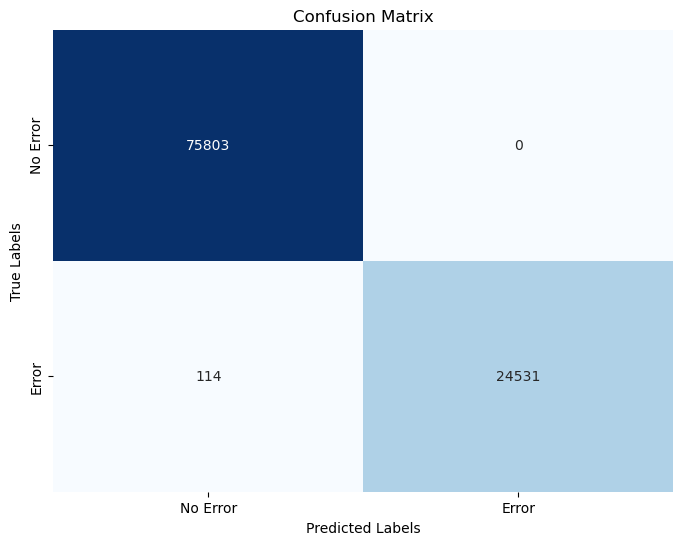

In [41]:
def plot_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No Error', 'Error'], yticklabels=['No Error', 'Error'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(labels, predictions)

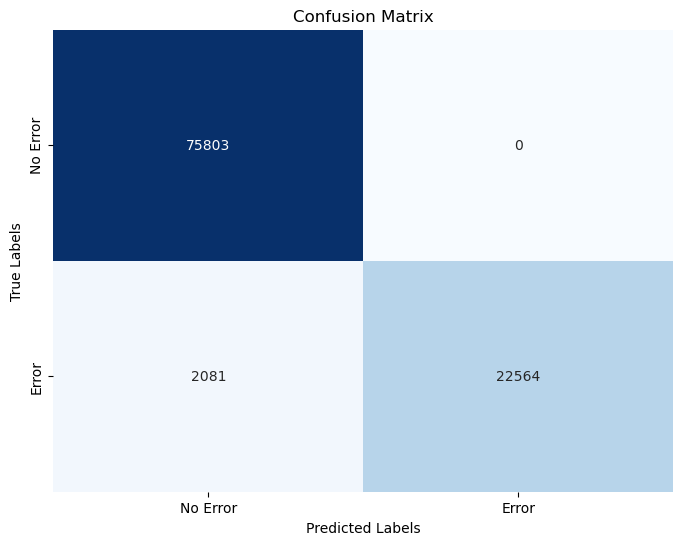

In [42]:
plot_confusion_matrix(labels, all_predictions_iou) # for threshold of 0.99 would be 47 errors